In [50]:
# Import SQL Alchemy
import sqlalchemy 
from sqlalchemy import create_engine
from sqlalchemy.orm import Session

# Import and establish Base for which classes will be constructed 
from sqlalchemy.ext.automap import automap_base

# Import modules to declare columns and column data types
from sqlalchemy import Column, Integer, String, Float, inspect, MetaData, Table, func

from datetime import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [51]:
# Create an engine to a SQLite database file called `hawaii.sqlite`
engine = create_engine("sqlite:///hawaii.sqlite")

# engine.execute('SELECT * FROM weather_measurements LIMIT 5').fetchall()
# engine.execute('SELECT * FROM weather_stations LIMIT 5').fetchall()

In [52]:
# Declare a Base using `automap_base()` OR assign Base the automap functionality
Base = automap_base()

In [53]:
# Use the Base class to reflect the database tables from engine. Automap base converts tables to classes automatically 
Base.prepare(engine, reflect=True)

In [54]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurements', 'stations']

In [55]:
# Reflect tables into classes and save a reference to those classes called `Station` and `Measurement`. 
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [56]:
# Create a session
session = Session(engine)

In [57]:
# 1) engine.execute('select * from weather_measurements').fetchall()
# 2) inspector is also used to retrieve data   # for structure
# 3) select * from table (not class) will work? Below is 4th method.... what is the differnce?
for row in session.query(Stations, Stations.station).limit(3).all():   #for classes
    print(row)
for row in session.query(Measurements, Measurements.date, Measurements.prcp).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.stations object at 0x00000232E3D9A9B0>, 'USC00519397')
(<sqlalchemy.ext.automap.stations object at 0x00000232E3D9A6A0>, 'USC00513117')
(<sqlalchemy.ext.automap.stations object at 0x00000232E3D9A550>, 'USC00514830')
(<sqlalchemy.ext.automap.measurements object at 0x00000232E3DAF710>, '2010-01-01', 0.08)
(<sqlalchemy.ext.automap.measurements object at 0x00000232E3DAFA90>, '2010-01-02', 0.0)
(<sqlalchemy.ext.automap.measurements object at 0x00000232E3DAF550>, '2010-01-03', 0.0)
(<sqlalchemy.ext.automap.measurements object at 0x00000232E3DAF128>, '2010-01-04', 0.0)
(<sqlalchemy.ext.automap.measurements object at 0x00000232E3DAFB00>, '2010-01-07', 0.06)


In [101]:
# PRECIPITATION ANALYSIS

# Query to retrieve the last 12 months of precipitation data using only `date` and `prcp` values.

sel = [Measurements.date, Measurements.prcp]
prcp12_data = session.query(*sel).\
    filter(func.strftime("%YY/%m/%d", Measurements.date) >= "2017/01/01").all()
    
prcp12_dict = dict(prcp12_data)
prcp12_df = pd.DataFrame.from_dict(prcp12_dict, orient='index', dtype=None)
prcp12_df = prcp12_df.reset_index()
prcp12_df.columns = ['date', 'prcp']
prcp12_df = prcp12_df.set_index('date')

prcp12_df.head()

,prcp
date,
2017-01-01,0.03
2017-01-02,0.00
2017-01-03,0.00
2017-01-04,0.00
2017-01-05,0.47


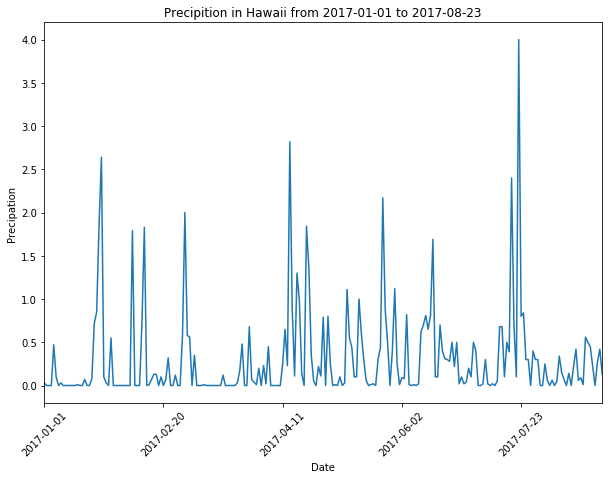

In [102]:
prcp12_df.plot(figsize = (10,7), rot = 45, use_index = True, legend=False)
plt.ylabel('Precipation')
plt.xlabel('Date')
plt.title("Precipition in Hawaii from %s to %s" % (prcp12_df.index.min(),prcp12_df.index.max()))
plt.show()

In [103]:
#STATION ANALYSIS

station_data = session.query(Stations).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x232e3e5d898>,
 'elavation': 3.0,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [104]:
number_of_stations = session.query(Stations.station).count()
number_of_stations

9

In [105]:
sel = [Stations.station, Stations.name, func.count(Measurements.tobs)]
stations_activity = session.query(*sel).\
filter(Stations.station == Measurements.station).group_by(Measurements.station).\
order_by(func.count(Measurements.tobs).desc()).all()

stations_activity    # Most active stations are on top - listed in descending order

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

In [106]:
# The most active station
max_stations_activity = stations_activity[0][0:2]
max_stations_activity

('USC00519281', 'WAIHEE 837.5, HI US')

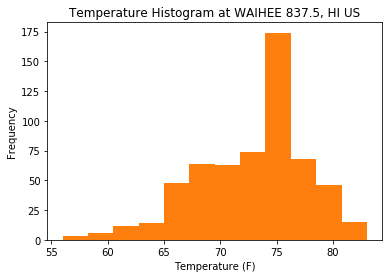

In [116]:
# Query to retrieve the last 12 months of temperature observation data (tobs).

tobs12_data = session.query(Measurements.station, Measurements.tobs).\
filter(Measurements.station == max_stations_activity[0]).filter(func.strftime("%YY/%m/%d", Measurements.date)>= "2016-01-01").all()

temps = [x[1] for x in tobs12_data]
plt.hist(temps, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Histogram at %s" % (max_stations_activity[1]))
plt.show()

In [167]:
# TEMPERATURE ANALYSIS 

# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

calc_temps_dict = calc_temps('2017-07-31', '2017-08-10')

print("Min Temp = %2.2f,   Avg Temp = %2.2f,   Max Temp = %2.2f" \
    % (calc_temps_dict[0][0], calc_temps_dict[0][1], calc_temps_dict[0][2]))

Min Temp = 71.00,   Avg Temp = 79.10,   Max Temp = 83.00


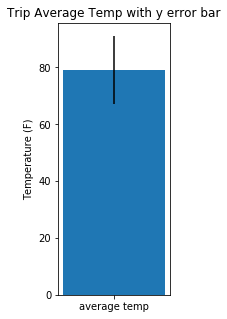

In [168]:
# create bar graph
min_temp = calc_temps_dict[0][0]
avg_temp = calc_temps_dict[0][1]
max_temp = calc_temps_dict[0][2]
plt.figure(figsize=(2,5))
plt.title("Trip Average Temp with y error bar")
plt.ylabel("Temperature (F)")
plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "average temp")
plt.show()

In [ ]:
# ClIMATE APP

from flask import Flask
app = Flask(__name__)

@app.route(`/api/v1.0/precipitation`)
def hello_world():
    return 'Hello, World!'
